# Volume of Union of $N$ Spheres in 3D

Compute the volume of the union of $N$ spheres in 3D via the Monte Carlo method. To reduce computation, first construct a bounding box (a parallelpiped in 3D) around the collection of spheres, randomly distributed points inside the box, and count the fraction of points within the union and intersection of the spheres.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Volume Calculation

In [2]:
def bounding_volume(x, R):
    """Return the volume and corners of a parallelpiped containing the
    n input spheres of interest.
    
    Parameters
    ----------
    x : ndarray
        Centers of n input spheres (n x 3 array).
    R : ndarray
        Radii of n input spheres (n x 1 array).

    Returns
    -------
    vol : float
        Volume of parallelpiped.
    xmin : ndarray
        Lower corner of volume.
    xmax : ndarray
        Upper corner of volume.
    """
    n, d = x.shape
    
    # Compute the corners of the bounding parallelpiped containing
    # the group of spheres. Then store the volume.
    xmin = np.copy(x[-1])
    xmax = np.copy(xmin)

    for i in range(n):
        xmin = np.minimum(xmin, x[i] - R[i])
        xmax = np.maximum(xmax, x[i] + R[i])
    vol = np.prod(xmax - xmin)
    
    return vol, xmin, xmax

def volume_of_spheres(x, R, nsamples=10000):
    """Obtain the volume, with uncertainties, of the intersection and union of
    n spherical volumes using Monte Carlo sampling.

    Parameters
    ----------
    x : ndarray
        Centers of n input spheres (n x 3 array).
    R : ndarray
        Radii of n input spheres (n x 1 array).
    nsamples : int
        Number of Monte Carlo samples to generate.

    Returns
    -------
    ivol : float
        Volume of intersecting regions of *all* spheres.
    idv : float
        Uncertainty in intersection volume due to Monte Carlo shot noise.
    uvol : float
        Volume of union of spheres.
    udv : float
        Uncertainty in union volume.
    """
    n, d = x.shape
    R2 = R**2
    
    vol, xmin, xmax = bounding_volume(x, R)

    # Track unions and joint intersections per spherical volume.
    n_inter, n_union = 0, 0
    
    for iobs in range(nsamples):
        obsd = np.random.uniform(low=xmin, high=xmax)

        ioint = True
        uoint = False

        for i in range(n):
            z2 = np.sum((obsd - x[i])**2)
            internal = z2 <= R2[i]
            
            # Track union and intersection. Note that intersection
            # looks for the intersecting regions of *all n* spheres,
            # not pairs of spheres.
            uoint = uoint or internal
            ioint = ioint and internal

        if ioint:
            n_inter += 1
        if uoint:
            n_union += 1

    # Calculate intersecting volume and accuracy.
    izp = n_inter / nsamples
    izq = (nsamples - n_inter) / nsamples

    ivol = vol * izp
    isigma = np.sqrt(izp * izq / nsamples)
    idv = vol * isigma

    # Calculate union volume and accuracy.
    uzp = n_union / nsamples
    uzq = (nsamples - n_union) / nsamples

    uvol = vol * uzp
    usigma = np.sqrt(uzp * uzq / nsamples)
    udv = vol * usigma

    return ivol, idv, uvol, udv

## Plotting Code

In [3]:
def draw_spheres(x, R):
    """Draw n overlapping spheres in a 3D plot.

    Parameters
    ----------
    x : ndarray
        Centers of n input spheres (n x 3 array).
    R : ndarray
        Radii of n input spheres (n x 1 array).
        
    Returns
    -------
    fig : matplotlib.Figure
        Figure object.
    ax : matplotlib.Axes
        Axis object.
    """
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-45, elev=30)

    phi, theta = np.mgrid[0.:np.pi:100j, 0.:2.*np.pi:100j]

    for i in range(len(R)):
        x_ = x[i,0] + R[i]*np.sin(phi)*np.cos(theta)
        y_ = x[i,1] + R[i]*np.sin(phi)*np.sin(theta)
        z_ = x[i,2] + R[i]*np.cos(phi)

        ax.plot_surface(x_, y_, z_,
                        rstride=1, cstride=1,
                        alpha=0.4,
                        linewidth=0)

    vol, xmin, xmax = bounding_volume(x, R)
    xlo, xhi = np.min(xmin), np.max(xmax)
    
    ax.set(xlim=(xlo, xhi), xlabel='$x$',
           ylim=(xlo, xhi), ylabel='$y$',
           zlim=(xlo, xhi), zlabel='$z$')
    
    return fig, ax

## Examples
### One Unit Sphere

In [4]:
# Array centers and radii.
x = np.asarray([[0.,0.,0.]])
R = np.asarray([1.])

One unit sphere should have volume

$$
V = \frac{4}{3}\pi \approx 4.189
$$

In [5]:
iv, idv, uv, udv = volume_of_spheres(x, R)
print('ivol = {:.3f} +- {:.3f}\nuvol = {:.3f} +- {:.3f}'.format(iv, idv, uv, udv))

ivol = 4.193 +- 0.040
uvol = 4.193 +- 0.040


<IPython.core.display.Javascript object>


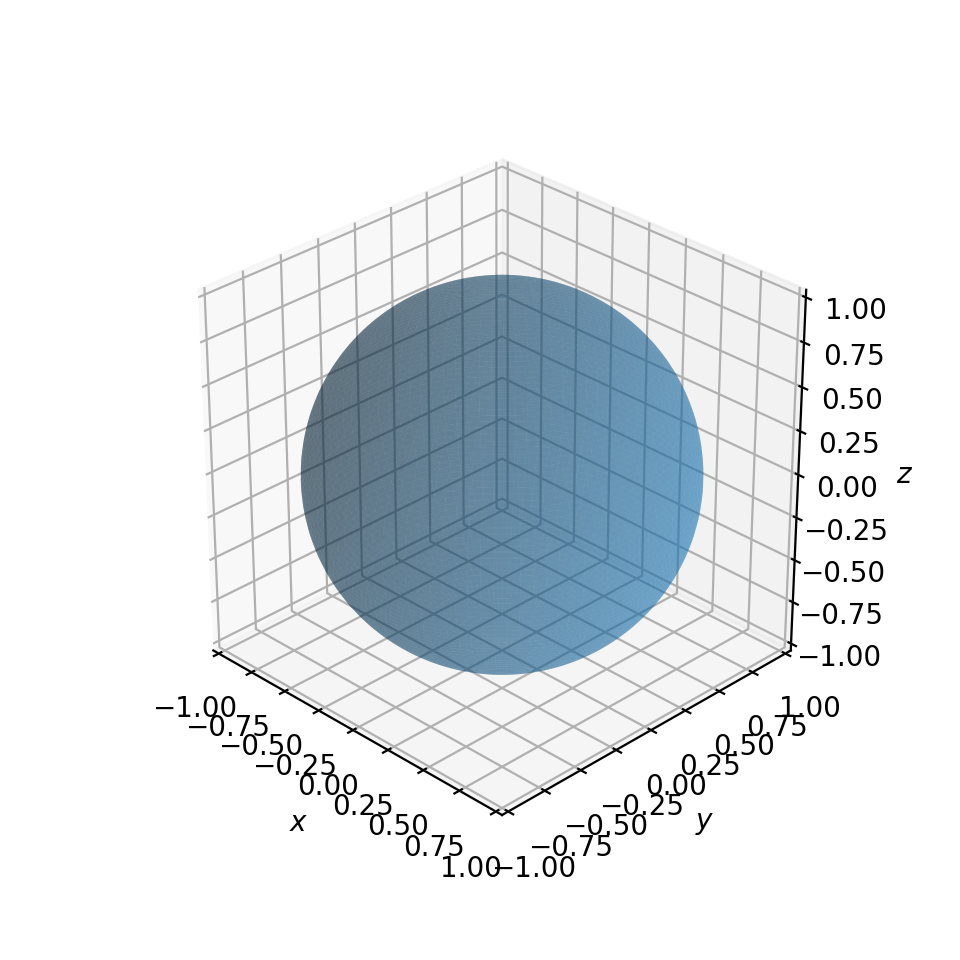

In [6]:
fig, ax = draw_spheres(x, R)

### Two Unit Spheres Displaced along the $z$-axis

Displace one sphere along $z$ by $2r=2$ so that the spheres just barely touch at one point. The volume will be

$$
V = 2*\frac{4}{3}\pi \approx 8.378
$$

In [7]:
# Array centers and radii.
x = np.asarray([[0.,0.,0.], [0.,0.,2.]])
R = np.asarray([1.,1.])

In [8]:
iv, idv, uv, udv = volume_of_spheres(x, R)
print('ivol = {:.3f} +- {:.3f}\nuvol = {:.3f} +- {:.3f}'.format(iv, idv, uv, udv))

ivol = 0.000 +- 0.000
uvol = 8.392 +- 0.080


<IPython.core.display.Javascript object>


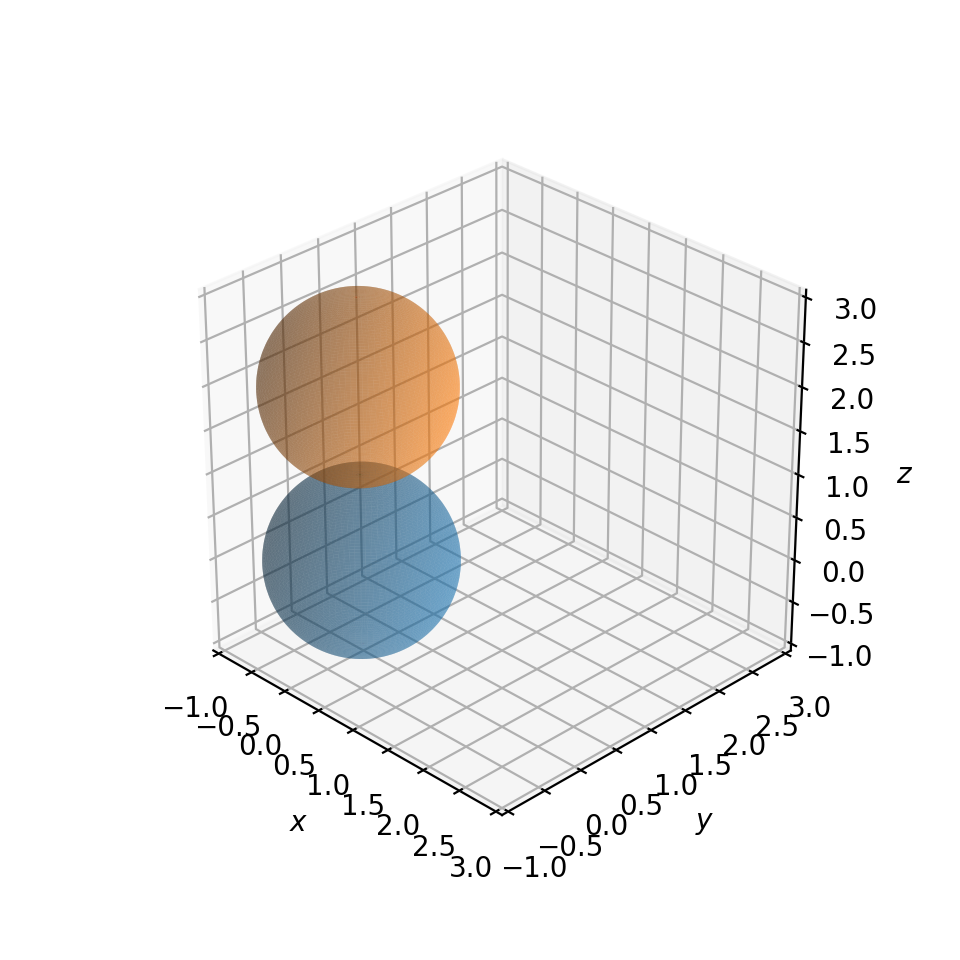

In [9]:
fig, ax = draw_spheres(x, R)

### Two Unit Spheres Overlapping, Separated by Distance $d$

The volume of two overlapping spheres is given by $V=V_1+V_2-V_{12}$, where $V_{12}$ is the intersecting "lens" formed by the overlap of two spherical caps between the spheres. If the distance separating the centers of the spheres is $d$ and their radii are both $R$ then the volume of one spherical cap is

$$
V_\mathrm{cap} = \frac{\pi R^3}{3}\left(1-\cos{\theta}\right)^2\left(2+\cos{\theta}\right),
$$

where

$$
\cos{\theta} = \frac{d}{2R}
$$

if $d<2R$. Thus

$$
V_\mathrm{lens} = 2V_\mathrm{cap}
$$

and the union of the two spheres has volume

$$
V = \frac{8\pi R^3}{3} - V_\mathrm{lens}.
$$

In [10]:
# Array centers and radii.
d = 1.5

x = np.asarray([[0.,0.,0.], [0.,0.,d]])
R = np.asarray([1.,1.])

Compare Monte Carlo and analytical solution.

In [11]:
iv, idv, uv, udv = volume_of_spheres(x, R, nsamples=10000)
print('ivol = {:.3f} +- {:.3f}\nuvol = {:.3f} +- {:.3f}'.format(iv, idv, uv, udv))

ivol = 0.336 +- 0.021
uvol = 8.036 +- 0.069


In [12]:
costh = d/2
Vcap = np.pi/3 * (1-costh)**2 * (2+costh)
Vlens = 2*Vcap
print('Vlens = {:.3f}'.format(Vlens))
print('union = {:.3f}'.format(8*np.pi/3 - Vlens))

Vlens = 0.360
union = 8.018


<IPython.core.display.Javascript object>


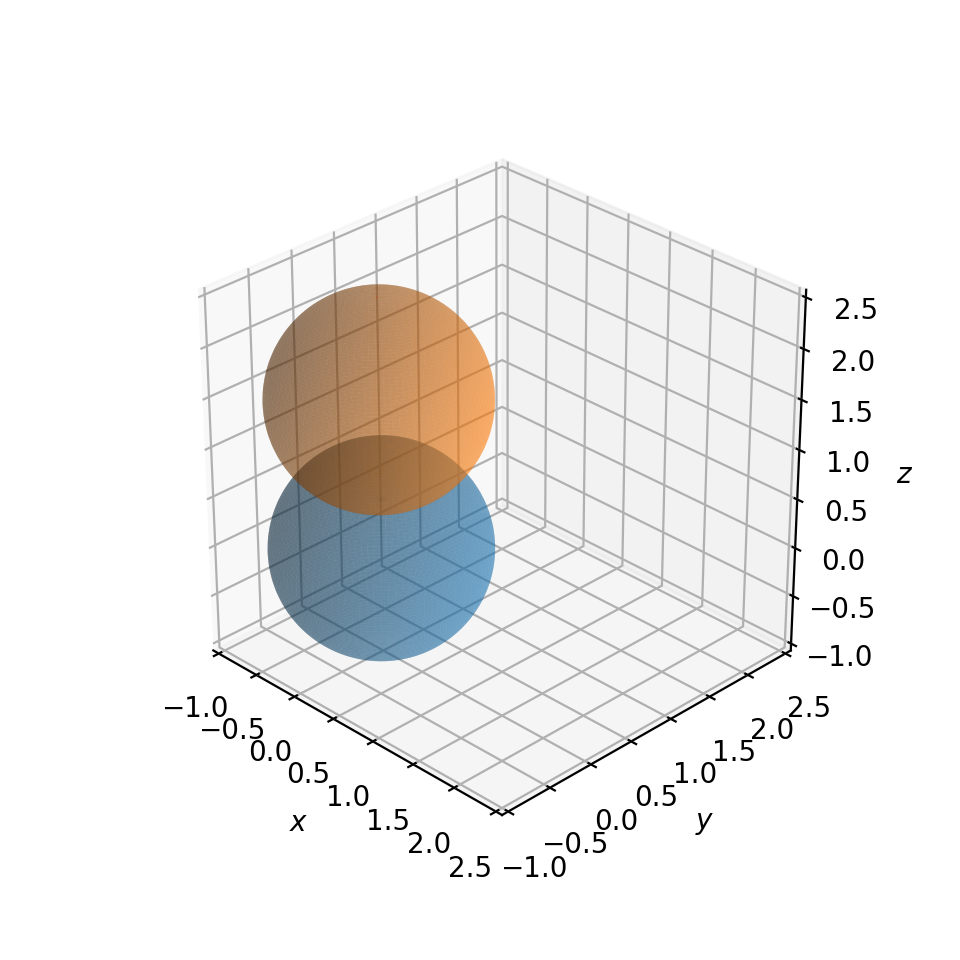

In [13]:
fig, ax = draw_spheres(x, R)

Just as a sanity check, move the two spheres even closer so that $d<R$.

In [14]:
# Array centers and radii.
d = 0.5

x = np.asarray([[0.,0.,0.], [0.,0.,d]])
R = np.asarray([1.,1.])

Compare the Monte Carlo and analytical solutions.

In [15]:
iv, idv, uv, udv = volume_of_spheres(x, R, nsamples=10000)
print('ivol = {:.3f} +- {:.3f}\nuvol = {:.3f} +- {:.3f}'.format(iv, idv, uv, udv))

ivol = 2.690 +- 0.044
uvol = 5.746 +- 0.049


In [16]:
costh = d/2
Vcap = np.pi/3 * (1-costh)**2 * (2+costh)
Vlens = 2*Vcap
print('Vlens = {:.3f}'.format(Vlens))
print('union = {:.3f}'.format(8*np.pi/3 - Vlens))

Vlens = 2.651
union = 5.727


<IPython.core.display.Javascript object>


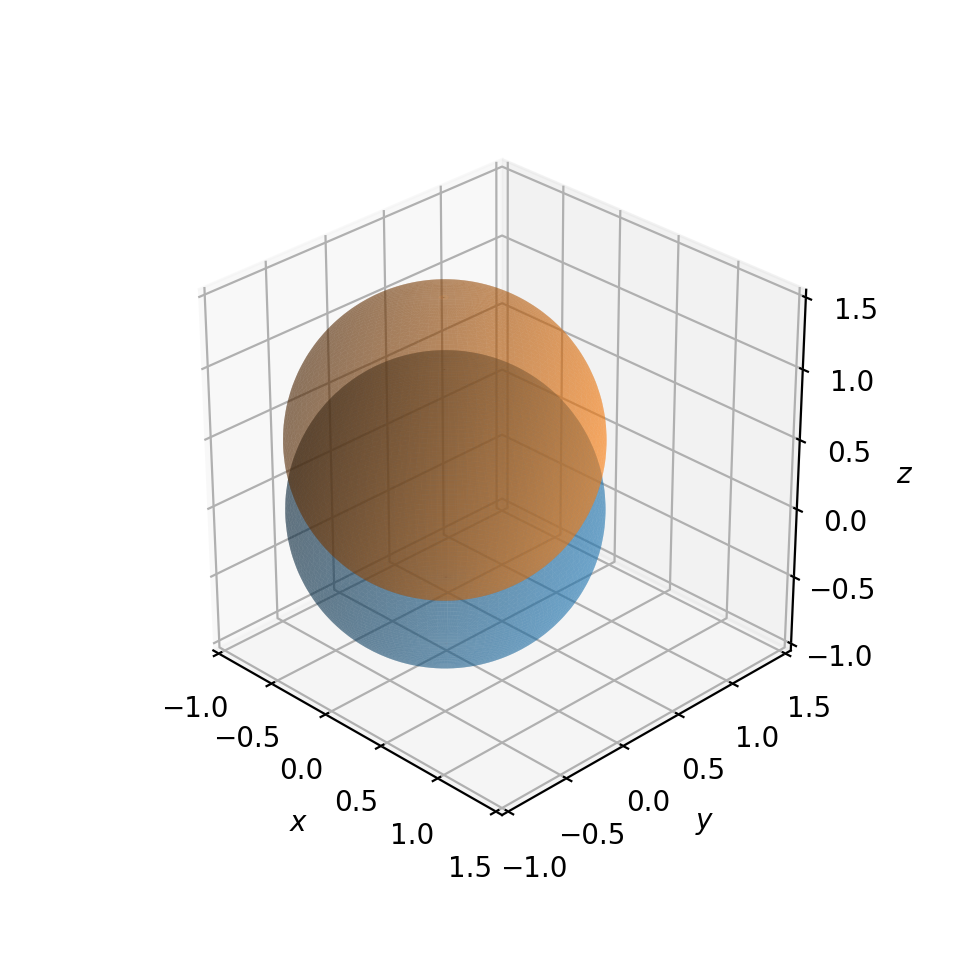

In [17]:
fig, ax = draw_spheres(x, R)

### Two Concentric Spheres, or One Sphere $R_1$ within a second $R_2$

The union of two concentric spheres, or one sphere totally within a second sphere, should just be the volume of the larger sphere.

In this example, set both spheres at the origin and let $R_2=1$, $R_1=R_2/2$.

In [18]:
# Array centers and radii.
x = np.asarray([[0.,0.,0.], [0.25,0.25,0.25]])
R = np.asarray([0.5,1.])

In [19]:
iv, idv, uv, udv = volume_of_spheres(x, R)
print('ivol = {:.3f} +- {:.3f}\nuvol = {:.3f} +- {:.3f}'.format(iv, idv, uv, udv))

ivol = 0.506 +- 0.019
uvol = 4.146 +- 0.040


In [20]:
# Analytical solution:
print('inter = {:.3f}'.format(4*np.pi/3 * R[0]**3))
print('union = {:.3f}'.format(4*np.pi/3))

inter = 0.524
union = 4.189


<IPython.core.display.Javascript object>


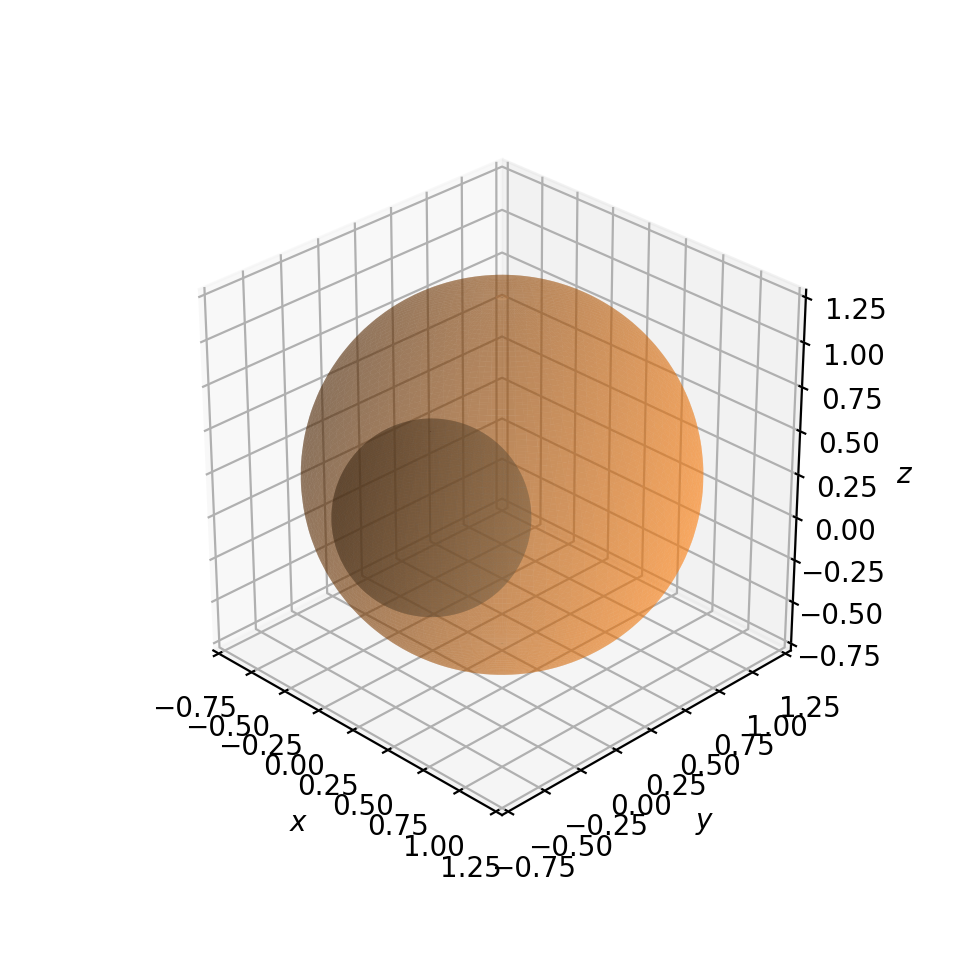

In [21]:
fig, ax = draw_spheres(x, R)

### Three Spheres

The analytic solution gets tricky because of the various determinant conditions one must evaluate to determine intersection. But the Monte Carlo solution is easy.

In [22]:
# Array centers and radii.
x = np.asarray([[0.,0.,0.], [0.,0.,1.5], [1.,1.,1.]])
R = np.asarray([1.5,0.9,0.8])

In [23]:
iv, idv, uv, udv = volume_of_spheres(x, R)
print('ivol = {:.3f} +- {:.3f}\nuvol = {:.3f} +- {:.3f}'.format(iv, idv, uv, udv))

ivol = 0.030 +- 0.011
uvol = 17.965 +- 0.210


Note that the intersection volume may be very small because the code is set up to compute the regions where *all* spheres intersect, not just pairs of spheres.

<IPython.core.display.Javascript object>


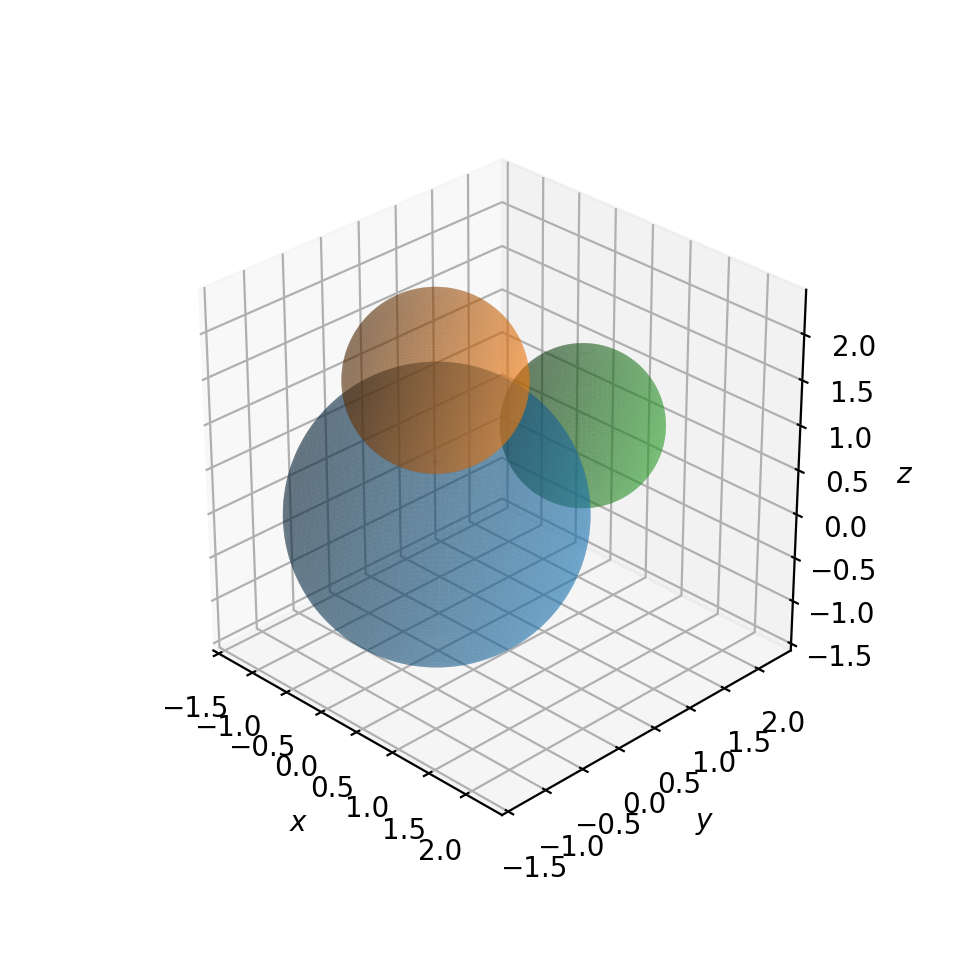

In [24]:
fig, ax = draw_spheres(x, R)

### Randomly Generated Set of Spheres

In [29]:
x = np.random.uniform(-1,3, size=(6,3))
R = np.random.uniform(0.5,2, size=6)

In [30]:
iv, idv, uv, udv = volume_of_spheres(x, R)
print('ivol = {:.3f} +- {:.3f}\nuvol = {:.3f} +- {:.3f}'.format(iv, idv, uv, udv))

ivol = 0.000 +- 0.000
uvol = 64.528 +- 1.026


Just as a sanity check, compute the total volume of all spheres, ignoring overlaps.

In [31]:
print('total volume = {:.3f}'.format(np.sum(4/3*np.pi*R**3)))

total volume = 71.025


<IPython.core.display.Javascript object>


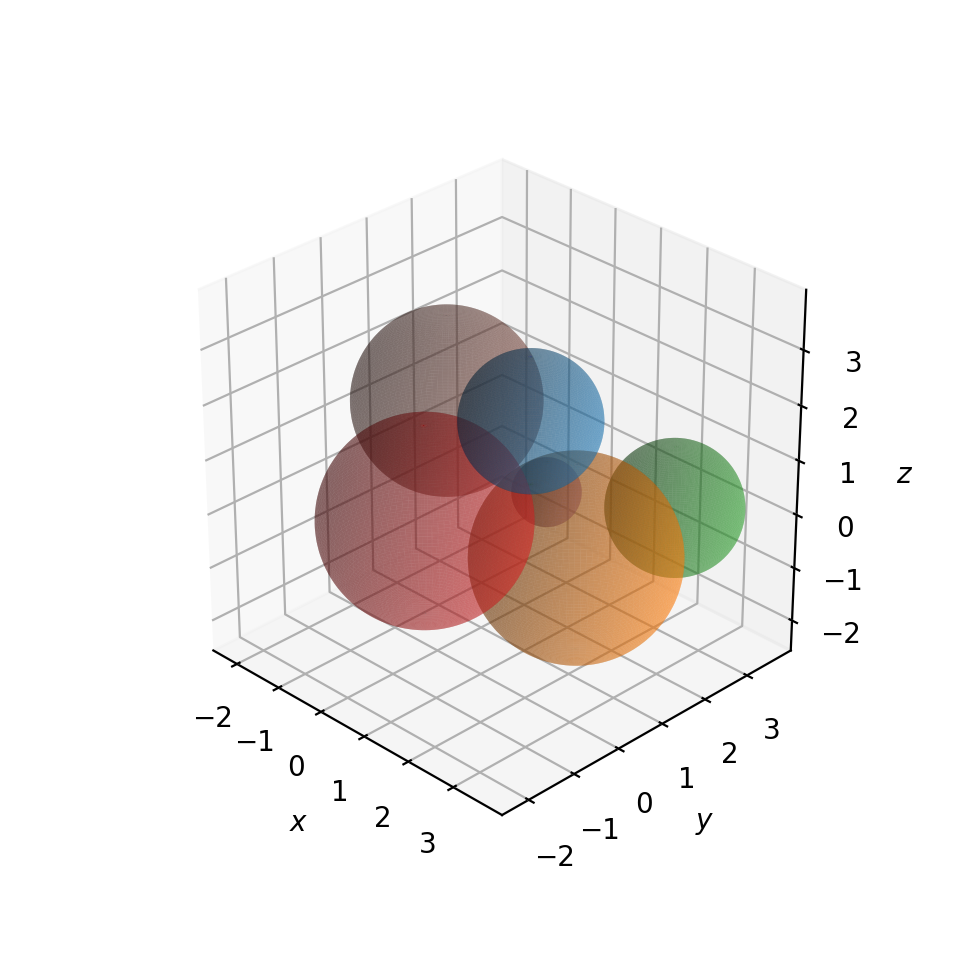

In [32]:
fig, ax = draw_spheres(x, R)